# Objetivo: Regressão no dataset "Real estate valuation" (UCI), usando MLP.
    - Avaliação por validação cruzada k-fold e análise de resíduos.


In [1]:
from ucimlrepo import fetch_ucirepo

import numpy as np
from sklearn.preprocessing import QuantileTransformer, StandardScaler
import random
import itertools


from trabalho_ic_aplicada.models import aux
from trabalho_ic_aplicada.models import reg_mlp

2025-08-19 20:30:16.797 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-note/Documents/Github/Trabalhos_IC_Aplicada


In [2]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

# Removendo a primeira coluna (X1 transaction date) que não é um atributo relevante, segundo analise.
X = X[:, 1:]

y = real_estate_valuation.data.targets.to_numpy().ravel()


k_fold = aux.validacao_cruzada_kfold(X,y,k=10)


### Random Search e Avaliação Melhor Caso MLP.

In [3]:


def cross_val_mlp(X, y, k_fold, layer_sizes, activation, epochs, lr):
    """
    Executa CV para um MLP com N camadas ocultas (definidas em layer_sizes),
    retorna média de R2 e todas as curvas de loss.
    """
    fold_r2 = []
    fold_losses = []
    for train_idx, test_idx in k_fold:
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx].reshape(-1,1), y[test_idx].reshape(-1,1)

        # Normaliza X (fit no treino, transform no teste)
        scaler = QuantileTransformer(
            n_quantiles=min(X_tr.shape[0], 1000),
            output_distribution='uniform'
        )
        X_tr_n = scaler.fit_transform(X_tr)
        X_te_n = scaler.transform(X_te)

        # Treina
        W, loss_hist = reg_mlp.train_mlp_regression(
            X_tr_n, y_tr,
            layer_sizes=layer_sizes,           # ex.: [D, H1, H2, 1]
            epochs=epochs,
            eta_i=lr, eta_f=lr,
            hidden_activation=activation,
            output_activation='linear',
            verbose=False
        )
        fold_losses.append(loss_hist)

        # Previsão
        y_pred = reg_mlp.predict_mlp_regression(X_te_n, W, activation, 'linear').reshape(-1,1)

        # Métrica (R²)
        _, _, r2, *_ = aux.calcular_metricas(y_te, y_pred, aux)
        fold_r2.append(r2)

    return np.mean(fold_r2), fold_losses


def random_search_2hidden(X, y, k_fold,
                          hidden1_list, hidden2_list,
                          activations, epochs_list, lrs,
                          n_iter=40, seed=42):
    """
    Busca aleatória para MLP com DUAS camadas ocultas.
    Otimiza H1 e H2 separadamente.

    Parâmetros:
        hidden1_list: lista de inteiros para nº de neurônios da 1ª oculta (H1)
        hidden2_list: lista de inteiros para nº de neurônios da 2ª oculta (H2)
        activations:  lista de strings (ex.: ['relu','tanh','sigmoid'])
        epochs_list:  lista de int
        lrs:          lista de floats (taxas de aprendizado)
        n_iter:       nº de configs aleatórias a avaliar
        seed:         semente para reprodutibilidade
    """
    random.seed(seed)
    np.random.seed(seed)

    # todas as combinações possíveis
    all_combinations = list(itertools.product(activations, hidden1_list, hidden2_list, epochs_list, lrs))
    # amostra aleatória
    sampled = random.sample(all_combinations, min(n_iter, len(all_combinations)))

    best = {'score': -np.inf}
    for act, h1, h2, ep, lr in sampled:
        layer_sizes = [X.shape[1], h1, h2, 1]
        mean_r2, _ = cross_val_mlp(X, y, k_fold, layer_sizes, act, ep, lr)
        print(f"Act={act:<7} H1={h1:3d} H2={h2:3d} Ep={ep:3d} LR={lr:.3g} → R²={mean_r2:.4f}")

        if mean_r2 > best['score']:
            best.update({
                'layer_sizes': layer_sizes,
                'activation': act,
                'epochs': ep,
                'lr': lr,
                'score': mean_r2
            })

    print("\n=== Best config (2 hidden) ===")
    print(best)
    return best

In [4]:

# 1) Grid search
activations   = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
epochs_list   = [100, 200, 300]

# 1) Random search
best_cfg = random_search_2hidden(
    X, y, k_fold,
    hidden1_list=[4, 8, 16, 32, 64],
    hidden2_list=[4, 8, 16, 32, 64],
    activations=activations,
    epochs_list=[100, 200, 300],
    lrs=[1e-3, 5e-3, 1e-2],
    n_iter=50,
    seed=42
)  # você pode ajustar n_iter

Act=relu    H1= 64 H2= 16 Ep=300 LR=0.001 → R²=0.6439
Act=sigmoid H1= 16 H2= 16 Ep=300 LR=0.001 → R²=0.6895
Act=sigmoid H1=  4 H2= 16 Ep=300 LR=0.005 → R²=0.6463
Act=leaky_relu H1=  8 H2= 64 Ep=200 LR=0.001 → R²=0.6446
Act=tanh    H1=  8 H2=  8 Ep=100 LR=0.01 → R²=0.0025
Act=tanh    H1=  4 H2= 16 Ep=300 LR=0.005 → R²=0.6141
Act=tanh    H1=  4 H2=  4 Ep=200 LR=0.001 → R²=0.6147
Act=sigmoid H1= 32 H2=  4 Ep=300 LR=0.005 → R²=0.6683


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: invalid value encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada

Act=leaky_relu H1=  8 H2= 32 Ep=300 LR=0.005 → R²=nan
Act=sigmoid H1= 16 H2=  8 Ep=200 LR=0.01 → R²=0.6670


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models

Act=leaky_relu H1=  4 H2=  8 Ep=300 LR=0.01 → R²=nan


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: invalid value encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada

Act=leaky_relu H1=  8 H2= 64 Ep=100 LR=0.01 → R²=nan
Act=relu    H1= 16 H2= 16 Ep=100 LR=0.001 → R²=0.6612
Act=sigmoid H1=  8 H2= 64 Ep=300 LR=0.01 → R²=0.6520
Act=relu    H1= 32 H2= 16 Ep=100 LR=0.005 → R²=0.0234
Act=tanh    H1= 64 H2= 32 Ep=100 LR=0.001 → R²=0.6698
Act=sigmoid H1=  4 H2= 32 Ep=200 LR=0.01 → R²=0.6454
Act=sigmoid H1=  4 H2= 32 Ep=200 LR=0.001 → R²=0.6763
Act=sigmoid H1= 16 H2=  4 Ep=200 LR=0.01 → R²=0.6519
Act=sigmoid H1= 64 H2= 64 Ep=300 LR=0.005 → R²=0.6793
Act=tanh    H1=  4 H2=  8 Ep=200 LR=0.005 → R²=0.6067
Act=relu    H1=  8 H2= 16 Ep=200 LR=0.005 → R²=0.0793
Act=relu    H1= 32 H2= 32 Ep=200 LR=0.005 → R²=0.1054
Act=sigmoid H1=  4 H2= 32 Ep=100 LR=0.001 → R²=0.6820
Act=relu    H1= 16 H2= 32 Ep=300 LR=0.005 → R²=0.2198
Act=sigmoid H1= 64 H2= 16 Ep=200 LR=0.01 → R²=0.6456


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias


Act=leaky_relu H1=  8 H2=  8 Ep=200 LR=0.005 → R²=nan
Act=relu    H1= 64 H2= 32 Ep=300 LR=0.01 → R²=-0.0041


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias


Act=leaky_relu H1=  4 H2= 64 Ep=300 LR=0.005 → R²=nan
Act=tanh    H1= 64 H2= 16 Ep=300 LR=0.001 → R²=0.6567
Act=tanh    H1=  4 H2=  4 Ep=100 LR=0.001 → R²=0.6374
Act=relu    H1=  4 H2=  8 Ep=100 LR=0.001 → R²=0.5744
Act=relu    H1= 32 H2= 16 Ep=100 LR=0.001 → R²=0.6497
Act=tanh    H1=  8 H2=  8 Ep=200 LR=0.01 → R²=0.0527
Act=leaky_relu H1= 32 H2= 16 Ep=100 LR=0.001 → R²=0.6328


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/

Act=leaky_relu H1= 64 H2= 32 Ep=300 LR=0.01 → R²=nan
Act=sigmoid H1=  4 H2=  4 Ep=300 LR=0.001 → R²=0.6735
Act=leaky_relu H1= 16 H2=  8 Ep=200 LR=0.001 → R²=0.6507
Act=leaky_relu H1= 32 H2=  8 Ep=300 LR=0.001 → R²=0.6508
Act=sigmoid H1= 32 H2= 32 Ep=100 LR=0.005 → R²=0.6804

=== Best config (2 hidden) ===
{'score': np.float64(0.6895155871964953), 'layer_sizes': [5, 16, 16, 1], 'activation': 'sigmoid', 'epochs': 300, 'lr': 0.001}


Erro Quadrático Médio (EQM): 63.6434 ± 44.0037
Raiz do Erro Quadrático Médio (REQM): 7.6076 ± 2.4018
Hit rate 20%: 0.7875 ± 0.0477
Hit rate 10%: 0.4926 ± 0.0807

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8383 ± 0.0111
Correlação Média (Teste): 0.8357 ± 0.0656
Coeficiente de Determinação (R²): 0.6828 ± 0.1089

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8250, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8362, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


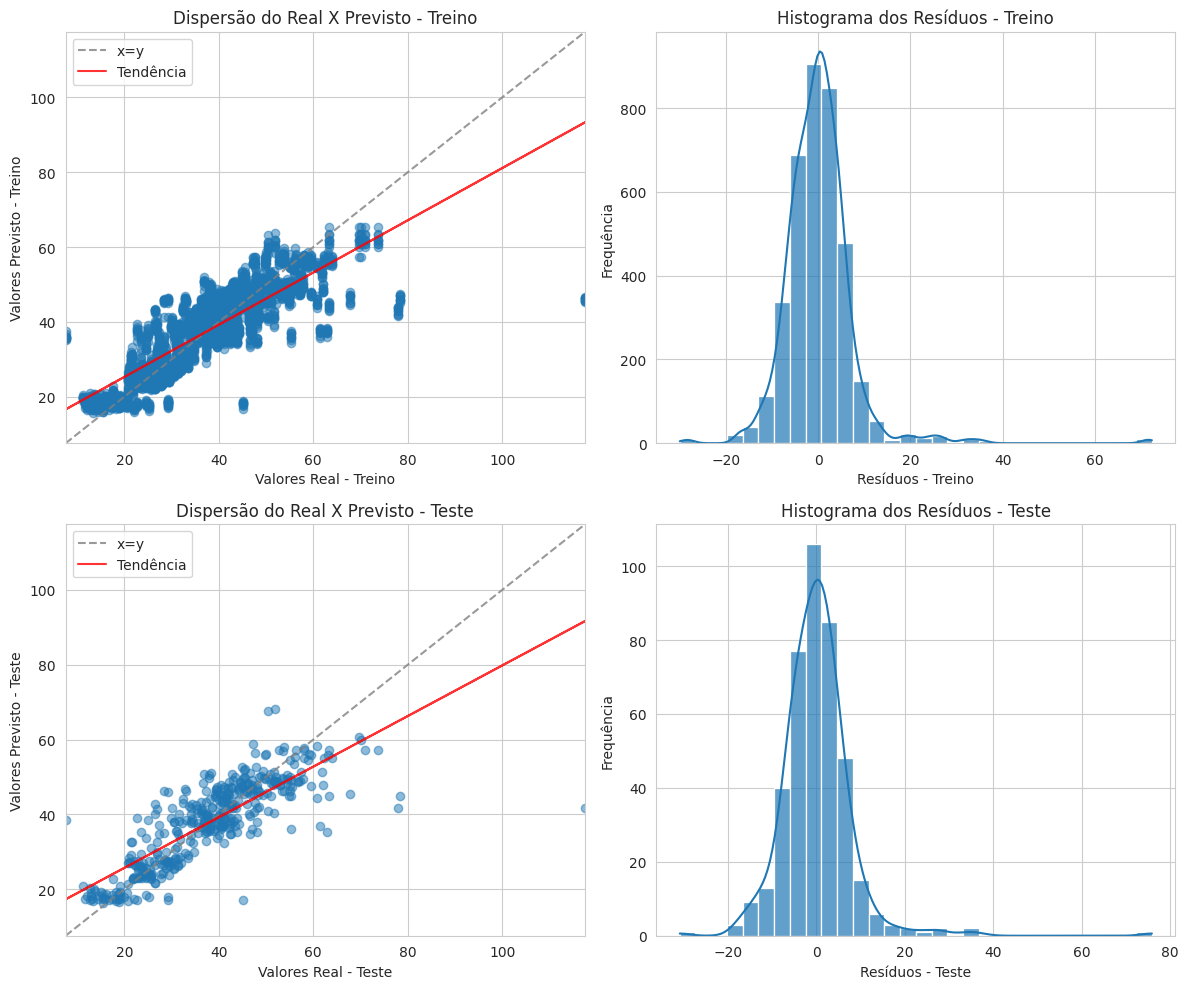

Avg. house price: 37.8727 ± 11.3367
RSME/Avg. house price: 0.1422 ± 0.1678


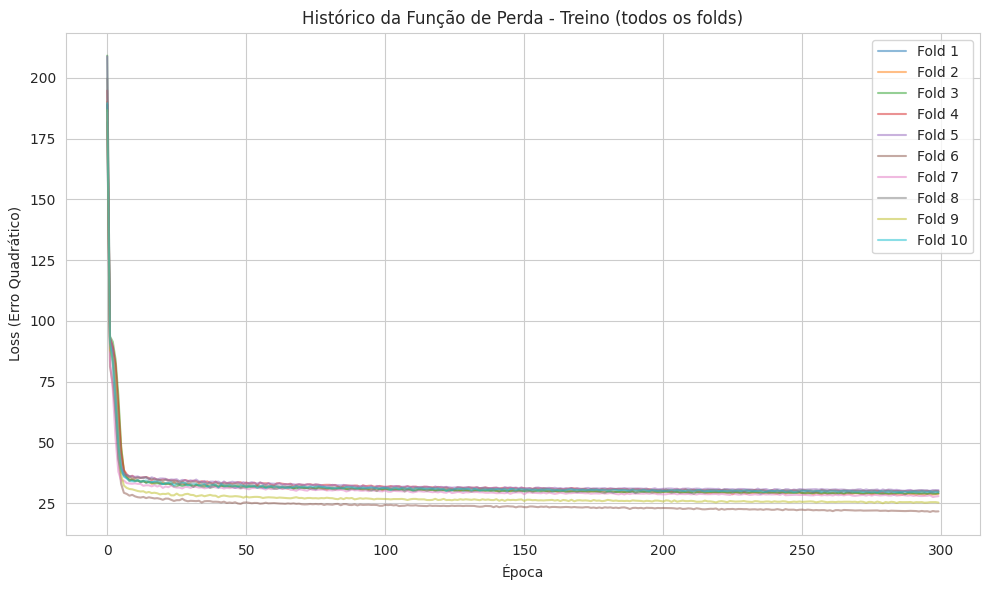

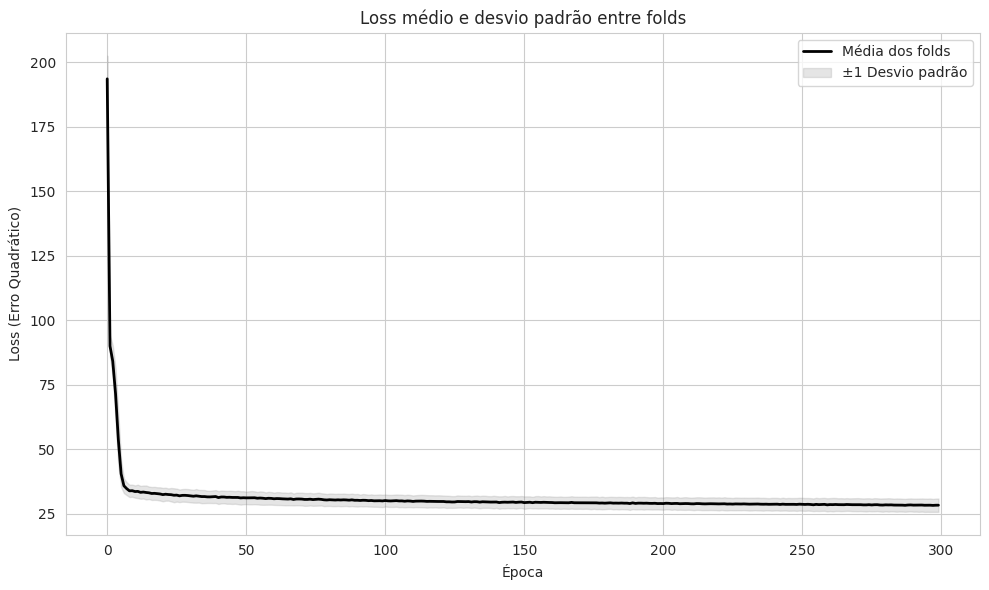

In [6]:

# best_cfg = grid_search(X, y, k_fold,
#                        hidden_units, activations,
#                        epochs_list, learning_rates)

# 2) Treino final com CV para coletar tudo
ls   = best_cfg['layer_sizes']
act  = best_cfg['activation']
ep   = best_cfg['epochs']
# ep = 300
lr   = best_cfg['lr']

all_train_losses = []
y_tr_all, y_trp_all = [], []
y_te_all, y_tep_all   = [], []
cor_tr, cor_te = [], []

eqms, reqms, r2s, h20, h10 = [], [], [], [], []


for train_idx, test_idx in k_fold:
    y_scaler = StandardScaler()

    # 2) Treino e teste
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx].reshape(-1,1), y[test_idx].reshape(-1,1)

    # Normaliza y (fit no treino, transform no teste)
    #
    # y_tr = y_scaler.fit_transform(y_tr)
    # y_te = y_scaler.transform(y_te)

    scaler = QuantileTransformer(n_quantiles=min(X_tr.shape[0],1000), output_distribution='uniform')
    X_tr_n = scaler.fit_transform(X_tr)
    X_te_n = scaler.transform(X_te)

    W, loss_hist = reg_mlp.train_mlp_regression(
        X_tr_n, y_tr, layer_sizes=ls,
        epochs=ep, eta_i=lr, eta_f=lr,
        hidden_activation=act, output_activation='linear',
        verbose=False
    )
    all_train_losses.append(loss_hist)

    y_trp = reg_mlp.predict_mlp_regression(X_tr_n, W, act, 'linear').reshape(-1,1)
    y_tep = reg_mlp.predict_mlp_regression(X_te_n, W, act, 'linear').reshape(-1,1)


    eqm, reqm, r2, hit_20, hit_10, _ = aux.calcular_metricas(y_te, y_tep, aux)
    eqms.append(eqm)
    reqms.append(reqm)
    r2s.append(r2)
    h20.append(hit_20)
    h10.append(hit_10)

    cor_tr.append(np.corrcoef(y_tr.flatten(), y_trp.flatten())[0,1])
    cor_te.append(np.corrcoef(y_te.flatten(), y_tep.flatten())[0,1])

    y_tr_all .extend(y_tr.flatten())
    y_trp_all.extend(y_trp.flatten())
    y_te_all .extend(y_te.flatten())
    y_tep_all.extend(y_tep.flatten())

# 3) Métricas finais
# eqms, reqms, r2s, h20, h10, _ = aux.calcular_metricas(
#     np.array(y_te_all), np.array(y_tep_all), aux)
aux.imprimir_metricas(eqms, reqms, r2s, h20, h10)
aux.imprimir_correlacoes(cor_tr, cor_te, r2s)
aux.analisar_residuos(
    np.array(y_tr_all), np.array(y_trp_all),
    np.array(y_te_all), np.array(y_tep_all),
    aux, titulo="MLP Final"
)
aux.calcular_metricas_normalizadas(y_tep_all, y_te_all)

# 4) Plots de loss
aux.plot_folds_loss(all_train_losses)


In [7]:
### Random Search (com normalizações) e avaliação final em hold-out
import itertools, random, time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import numpy as np

# -------------------------------
# Hold-out: treino/teste (fixo)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# K-fold APENAS no treino (k=5)
k_fold_train = aux.validacao_cruzada_kfold(X_train, y_train, k=5)

# Espaços de busca (mantive seus valores)
activations = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
epochs_list = [100, 200, 300]
hidden1_list = [4, 8, 16, 32, 64]
hidden2_list = [4, 8, 16, 32, 64]
learning_rates = [1e-3, 5e-3, 1e-2]
norm_options = ['none', 'zscore', 'minmax', 'iqr']  # NOVO


def make_scaler(name: str, n_samples: int):
    if name == 'none':
        class _NoOp:
            def fit(self, X): return self

            def transform(self, X): return X

            def fit_transform(self, X): return X

        return _NoOp()
    if name == 'zscore':
        return StandardScaler()
    if name == 'minmax':
        return MinMaxScaler()
    if name == 'iqr':
        return QuantileTransformer(
            n_quantiles=min(n_samples, 1000),
            output_distribution='uniform',
            random_state=42
        )
    raise ValueError(f"Normalização desconhecida: {name}")


def cross_val_mlp(
        X_in, y_in, k_fold, layer_sizes, activation, epochs, lr, norm_name
):
    """
    CV no TREINO para MLP (duas ocultas), saída linear, y não normalizado.
    Retorna (R² médio, lista de losses por fold).
    """
    fold_r2 = []
    fold_losses = []
    for train_idx, val_idx in k_fold:
        X_tr, X_va = X_in[train_idx], X_in[val_idx]
        y_tr, y_va = y_in[train_idx].reshape(-1, 1), y_in[val_idx].reshape(-1, 1)

        scaler_X = make_scaler(norm_name, X_tr.shape[0])
        X_tr_n = scaler_X.fit_transform(X_tr)
        X_va_n = scaler_X.transform(X_va)

        W, loss_hist = reg_mlp.train_mlp_regression(
            X_tr_n, y_tr,
            layer_sizes=layer_sizes,  # ex.: [D, H1, H2, 1]
            epochs=epochs,
            eta_i=lr, eta_f=lr,
            hidden_activation=activation,
            output_activation='linear',
            verbose=False
        )
        fold_losses.append(loss_hist)

        y_pred = reg_mlp.predict_mlp_regression(
            X_va_n, W, activation, 'linear'
        ).reshape(-1, 1)

        _, _, r2, *_ = aux.calcular_metricas(y_va, y_pred, aux)
        fold_r2.append(r2)

    return float(np.mean(fold_r2)), fold_losses


def random_search_2hidden_with_norm(
        X_in, y_in, k_fold,
        hidden1_list, hidden2_list,
        activations, epochs_list, lrs, norm_options,
        n_iter=40, seed=42
):
    """
    Random Search incluindo normalização em X. Mostra progresso e melhor até agora.
    """
    random.seed(seed);
    np.random.seed(seed)

    all_combos = list(itertools.product(norm_options, activations, hidden1_list, hidden2_list, epochs_list, lrs))
    sampled = random.sample(all_combos, min(n_iter, len(all_combos)))
    total = len(sampled)

    best = {'score': -np.inf}
    ranked = []
    t0 = time.time()

    for i, (norm_name, act, h1, h2, ep, lr) in enumerate(sampled, start=1):
        ls = [X_in.shape[1], h1, h2, 1]
        mean_r2, _ = cross_val_mlp(X_in, y_in, k_fold, ls, act, ep, lr, norm_name)

        ranked.append({
            'norm': norm_name, 'activation': act,
            'h1': h1, 'h2': h2,
            'epochs': ep, 'lr': lr,
            'r2_val_mean': mean_r2
        })

        if mean_r2 > best['score']:
            best.update({
                'norm': norm_name,
                'activation': act,
                'layer_sizes': ls,
                'epochs': ep,
                'lr': lr,
                'score': mean_r2
            })

        elapsed = time.time() - t0
        print(f"[{i}/{total}] norm={norm_name:<6} act={act:<10} H1={h1:>2} H2={h2:>2} Ep={ep:>3} LR={lr:<.3g} "
              f"→ R²cv={mean_r2:.4f} | best={best['score']:.4f} "
              f"({best['norm']},{best['activation']},H1={best['layer_sizes'][1]},H2={best['layer_sizes'][2]}) "
              f"| {elapsed:.1f}s")

    ranked_sorted = sorted(ranked, key=lambda d: -d['r2_val_mean'])
    print("\n=== TOP-10 (CV no TREINO) ===")
    for row in ranked_sorted[:10]:
        print(f"{row['norm']:>6} | {row['activation']:<10} | H1={row['h1']:>2} | H2={row['h2']:>2} | "
              f"Ep={row['epochs']:>3} | LR={row['lr']:<.3g} | R²={row['r2_val_mean']:.4f}")

    print("\n=== Melhor configuração (CV no TREINO) ===")
    print(best)
    return best, ranked_sorted


# -------------------------------
# Executa Random Search no TREINO
# -------------------------------
best_cfg, cv_rank = random_search_2hidden_with_norm(
    X_train, y_train, k_fold_train,
    hidden1_list, hidden2_list,
    activations, epochs_list, learning_rates, norm_options,
    n_iter=40, seed=42
)

# -------------------------------
# Reajuste no TREINO COMPLETO e avaliação no TESTE (hold-out)
# -------------------------------
norm_best = best_cfg['norm']
act_best = best_cfg['activation']
ls_best = best_cfg['layer_sizes']
ep_best = best_cfg['epochs']
lr_best = best_cfg['lr']

# Scaler final com a melhor normalização
scaler_X_final = make_scaler(norm_best, X_train.shape[0])
X_train_n = scaler_X_final.fit_transform(X_train)
X_test_n = scaler_X_final.transform(X_test)

# Treino final
W_best, loss_hist_best = reg_mlp.train_mlp_regression(
    X_train_n, y_train.reshape(-1, 1),
    layer_sizes=ls_best,
    epochs=ep_best,
    eta_i=lr_best, eta_f=lr_best,
    hidden_activation=act_best,
    output_activation='linear',
    verbose=False
)

# Predições (hold-out)
y_train_pred = reg_mlp.predict_mlp_regression(X_train_n, W_best, act_best, 'linear').reshape(-1, 1)
y_test_pred = reg_mlp.predict_mlp_regression(X_test_n, W_best, act_best, 'linear').reshape(-1, 1)

# Métricas no teste
eqm_t, rmse_t, r2_t, hit20_t, hit10_t, _ = aux.calcular_metricas(y_test.reshape(-1, 1), y_test_pred, aux)
print("\n=== DESEMPENHO NO TESTE (HOLD-OUT) ===")
print(f"R² = {r2_t:.4f} | RMSE = {rmse_t:.4f} | EQM = {eqm_t:.4f} | "
      f"Hit@10 = {hit10_t:.4f} | Hit@20 = {hit20_t:.4f}")

# Correlações (apenas hold-out)
corr_tr = np.corrcoef(y_train, y_train_pred.flatten())[0, 1]
corr_te = np.corrcoef(y_test, y_test_pred.flatten())[0, 1]
aux.imprimir_correlacoes([corr_tr], [corr_te], [r2_t])

# Resíduos (apenas hold-out)
aux.analisar_residuos(
    y_train, y_train_pred.flatten(),
    y_test, y_test_pred.flatten(),
    aux, titulo=f"MLP 2H — hold-out (norm={norm_best}, act={act_best}, H1={ls_best[1]}, H2={ls_best[2]})"
)

aux.calcular_metricas_normalizadas(y_test_pred.flatten(), y_test)

# Curva de perda do treino final
aux.plot_folds_loss(
    [loss_hist_best],
    titulo="Loss (treino final) — MLP 2H",
    ylabel="Erro Quadrático",
    xlabel="Época"
)


[1/40] norm=minmax act=leaky_relu H1=32 H2= 8 Ep=100 LR=0.001 → R²cv=0.6382 | best=0.6382 (minmax,leaky_relu,H1=32,H2=8) | 19.8s
[2/40] norm=none   act=relu       H1= 4 H2= 4 Ep=300 LR=0.001 → R²cv=-0.0164 | best=0.6382 (minmax,leaky_relu,H1=32,H2=8) | 76.6s
[3/40] norm=none   act=sigmoid    H1=16 H2= 8 Ep=200 LR=0.001 → R²cv=-0.0148 | best=0.6382 (minmax,leaky_relu,H1=32,H2=8) | 113.3s
[4/40] norm=iqr    act=tanh       H1=16 H2=16 Ep=200 LR=0.005 → R²cv=0.6241 | best=0.6382 (minmax,leaky_relu,H1=32,H2=8) | 149.8s
[5/40] norm=zscore act=tanh       H1= 4 H2= 4 Ep=100 LR=0.005 → R²cv=0.5405 | best=0.6382 (minmax,leaky_relu,H1=32,H2=8) | 174.2s
[6/40] norm=zscore act=sigmoid    H1=16 H2= 8 Ep=200 LR=0.005 → R²cv=0.6519 | best=0.6519 (zscore,sigmoid,H1=16,H2=8) | 214.4s


KeyboardInterrupt: 